In [1]:
from tensorflow import keras
from keras import layers
from pathlib import Path
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import json
from matplotlib import pyplot as plt
from collections import OrderedDict, Counter


In [2]:
DATADIR = "data/english_sentence"

params = {
    'model_cnn_bilstm_crf_path': str(Path(DATADIR, 'model_cnn_bilstm_crf')),
    'model_cnn_bilstm_dn_crf_path': str(Path(DATADIR, 'model_cnn_bilstm_dn_crf')),
    'model_bilstm_crf_path': str(Path(DATADIR, 'model_bilstm_crf')),
    'model_bilstm_dn_crf_path': str(Path(DATADIR, 'model_bilstm_dn_crf')),
    'full_model_cnn_bilstm_crf_path': str(Path(DATADIR, 'full_model_cnn_bilstm_crf')),
    'full_model_cnn_bilstm_dn_crf_path': str(Path(DATADIR, 'full_model_cnn_bilstm_dn_crf')),
    'full_model_bilstm_crf_path': str(Path(DATADIR, 'full_model_bilstm_crf')),
    'full_model_bilstm_dn_crf_path': str(Path(DATADIR, 'full_model_bilstm_dn_crf')),
    'model_histories_path': str(Path(DATADIR)),
    'words_path': str(Path(DATADIR, 'vocab.words.txt')),
    'chars_path': str(Path(DATADIR, 'vocab.chars.txt')),
    'tags_path': str(Path(DATADIR, 'vocab.tags.txt')),
    'sentences_path': (str(Path(DATADIR, 'train.words.txt')), str(Path(DATADIR, 'testa.words.txt')), str(Path(DATADIR, 'testb.words.txt'))),
    'labels_path': (str(Path(DATADIR, 'train.tags.txt')), str(Path(DATADIR, 'testa.tags.txt')), str(Path(DATADIR, 'testb.tags.txt'))),
}

In [3]:
def load_dataset_string(params:dict):
    # Loading dataset

    train_sentences = [x for x in Path(params['sentences_path'][0]).read_text().splitlines()]
    testa_sentences = [x for x in Path(params['sentences_path'][1]).read_text().splitlines()]
    testb_sentences = [x for x in Path(params['sentences_path'][2]).read_text().splitlines()]

    train_labels = [x.strip() for x in Path(params['labels_path'][0]).read_text().splitlines()]
    testa_labels = [x.strip() for x in Path(params['labels_path'][1]).read_text().splitlines()]
    testb_labels = [x.strip() for x in Path(params['labels_path'][2]).read_text().splitlines()]

    params['train_sentences'] = train_sentences
    params['testa_sentences'] = testa_sentences
    params['testb_sentences'] = testb_sentences
    
    params['train_labels'] = train_labels
    params['testa_labels'] = testa_labels
    params['testb_labels'] = testb_labels
    
load_dataset_string(params)


In [4]:
# model_name = "model_cnn_bilstm_dn_crf"
model_name = "model_cnn_bilstm_crf"
# model_name = "model_bilstm_dn_crf"
# model_name = "model_bilstm_crf"

model = keras.models.load_model(params[f"full_{model_name}_path"])

In [5]:
data = tf.constant([
    "From this point of view , I firmly believe that we should attach more importance to cooperation during primary education .",
])

print(model(data))
print(model.vectorizer_tags.get_vocabulary())

def decode_tags(model, tags_list):
    result = []
    index_to_tag = model.vectorizer_tags.get_vocabulary()
    for tags in tags_list:
        result.append([index_to_tag[i] for i in tags])
    return result

print(decode_tags(model, model(data)))

tf.Tensor(
[[ 3  3  3  3  3  3  3  3  3  3 11  5  5  5  5  5  5  5  5 10  3  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]], shape=(1, 73), dtype=int32)
['', '[UNK]', 'I-Premise', 'O', 'I-Claim', 'I-MajorClaim', 'E-Premise', 'B-Premise', 'E-Claim', 'B-Claim', 'E-MajorClaim', 'B-MajorClaim']
[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MajorClaim', 'I-MajorClaim', 'I-MajorClaim', 'I-MajorClaim', 'I-MajorClaim', 'I-MajorClaim', 'I-MajorClaim', 'I-MajorClaim', 'I-MajorClaim', 'E-MajorClaim', 'O', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']]


In [6]:
def missmatch(params, model):
    testa_sentences = params['testa_sentences'] 
    testb_sentences = params['testb_sentences']
    unseen_sentences = testa_sentences + testb_sentences
    
    testa_labels = params['testa_labels'] 
    testb_labels = params['testb_labels']
    unseen_labels = testa_labels + testb_labels
    
#     predicted_tags = model(unseen_sentences)
    results = []
    predicted_tags = decode_tags(model, model(unseen_sentences))
    for pred, real in zip(predicted_tags, unseen_labels):
        real = real.split(" ")
        pred = list(filter(lambda x: x, pred))
        if len(real) != len(pred):
            print(pred)
            print(real)
        results.append((real, pred))
    return results

results = missmatch(params, model)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


Accuracy: 0.6715544606054863


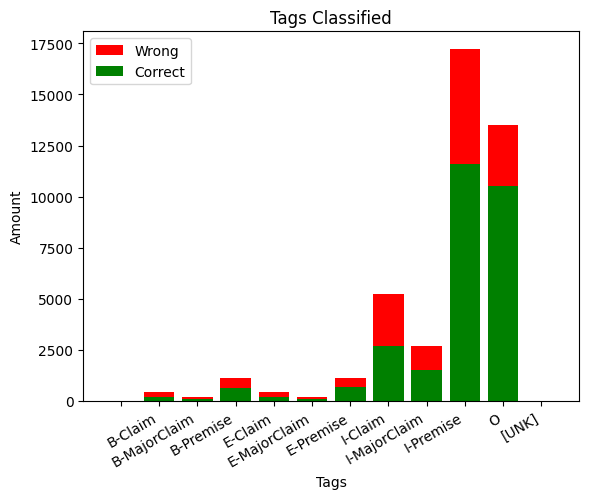

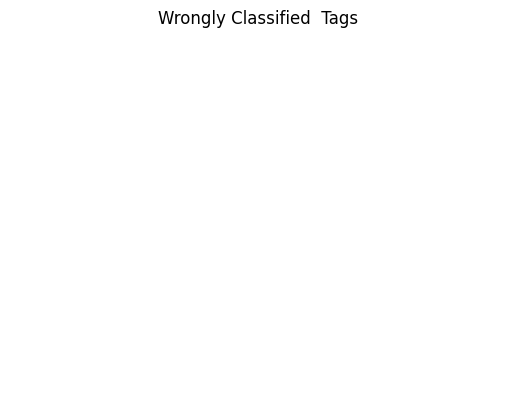

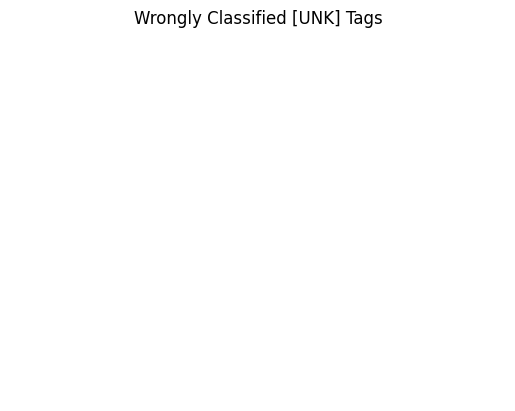

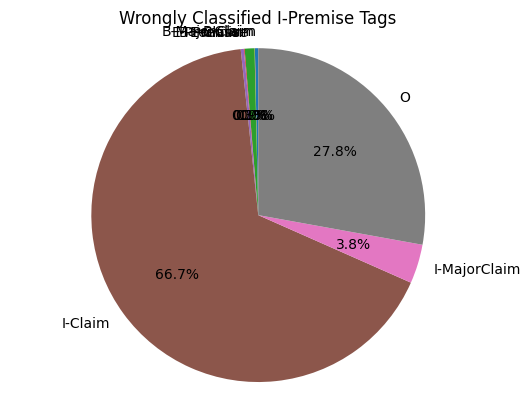

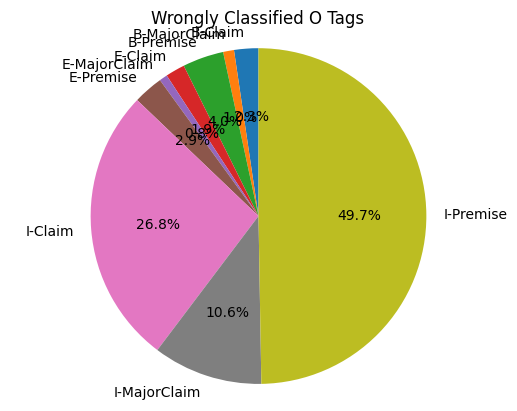

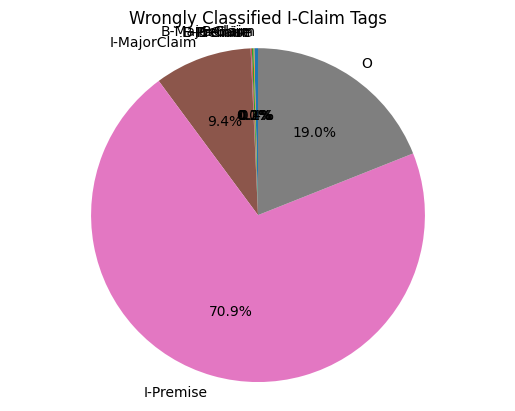

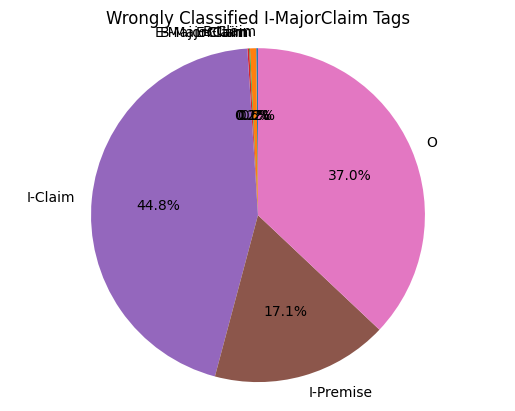

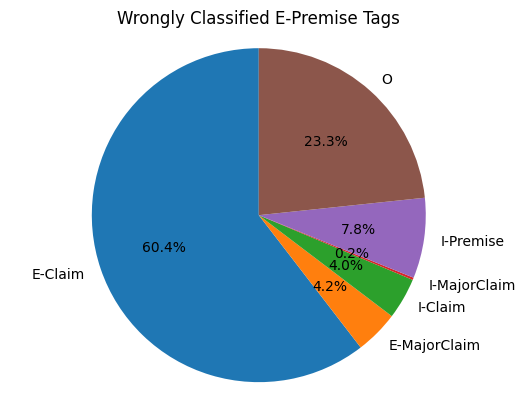

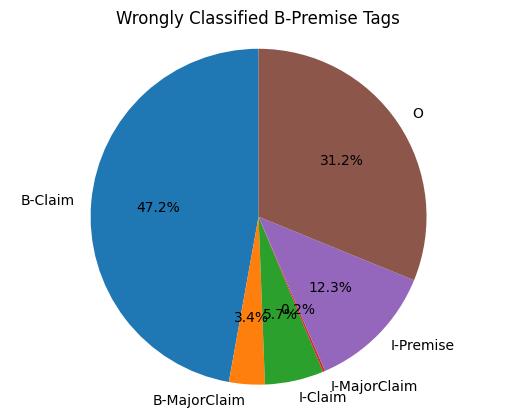

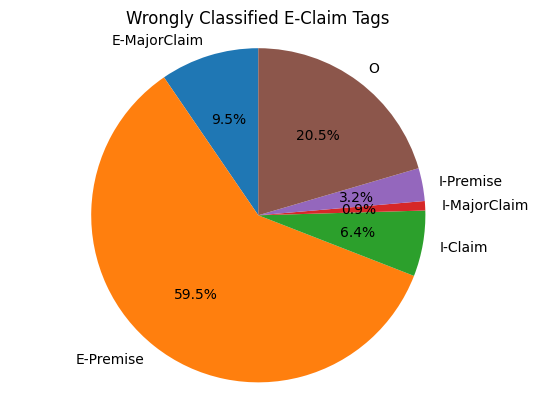

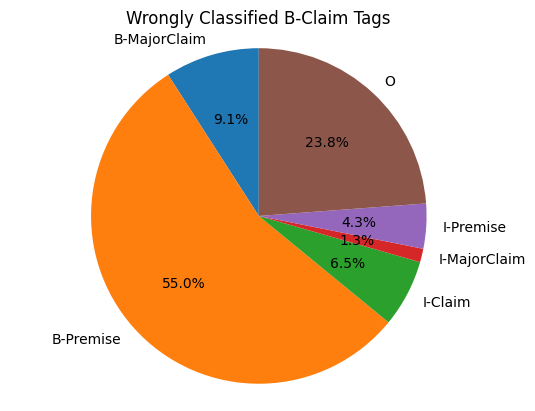

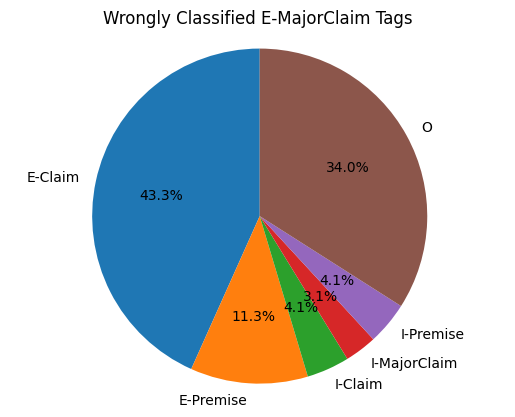

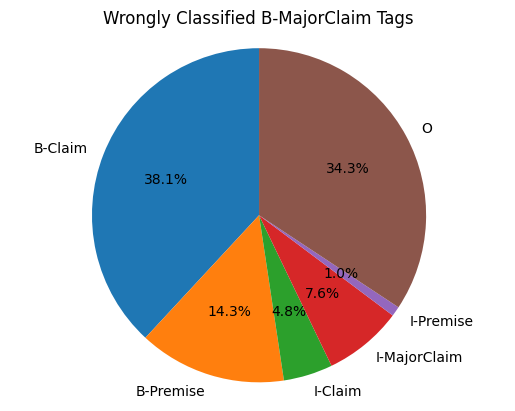

In [7]:

def result_analysis(results, model, with_meta_tags=True):
    tags = model.vectorizer_tags.get_vocabulary()
    
    def get_tag(tag):
        if not tag: return tag
        if with_meta_tags: return tag
        return tag[0]
    
    if not with_meta_tags:
        tags = list(OrderedDict({get_tag(tag):0 for tag in tags}))

    right_predictions = {
        tag: 0 for tag in tags
    }
    wrong_predictions = {
        tag: [] for tag in tags
    }
    total = 0
    correct = 0
    for real, pred in results:
        for real_tag, pred_tag in zip(real, pred):
            if not with_meta_tags:
                real_tag, pred_tag = get_tag(real_tag), get_tag(pred_tag)
            if real_tag != pred_tag:
                wrong_predictions[real_tag].append(pred_tag)
            else:
                right_predictions[real_tag] += 1
                correct += 1
            total += 1


    def plot_histogram():
        keys = sorted(list(right_predictions.keys()))
        plt.bar(keys, [right_predictions[key] + len(wrong_predictions[key]) for key in keys], color='r')
        plt.bar(keys, [right_predictions[key] for key in keys], color='g')
        plt.xticks(rotation=30, ha='right')
        plt.xlabel('Tags')
        plt.ylabel('Amount')
        plt.legend(["Wrong", "Correct"],loc=2)
        plt.title('Tags Classified')

        plt.show()

    def plot_pie_chart(tag):
        predictions = wrong_predictions[tag]
        counted = Counter(predictions)
        keys = sorted(counted.keys())
        
        labels = keys
        sizes = [counted[key] for key in keys]

        fig1, ax1 = plt.subplots()
        ax1.pie(sizes, 
                labels=labels, 
                autopct='%1.1f%%',
                startangle=90)
        ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        
        plt.title(f'Wrongly Classified {tag} Tags')
        plt.show()

    print("Accuracy:", correct/total)
        
    plot_histogram()
        
    for tag in tags:
        plot_pie_chart(tag)
        
result_analysis(results, model)

Accuracy: 0.8530582271284408


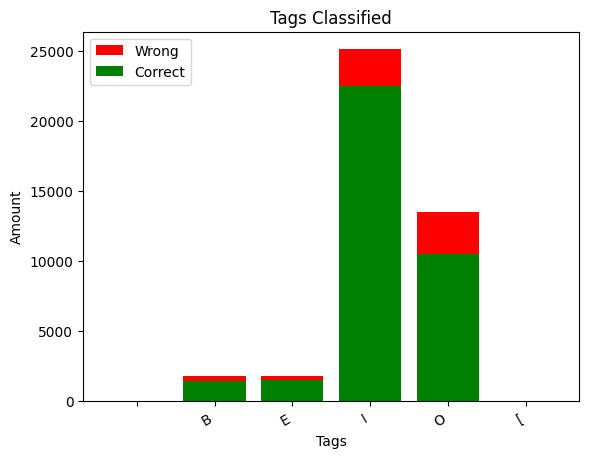

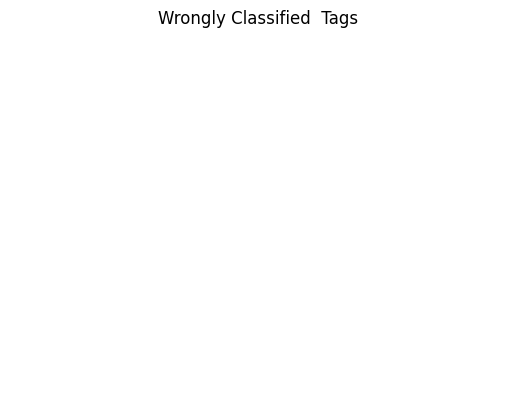

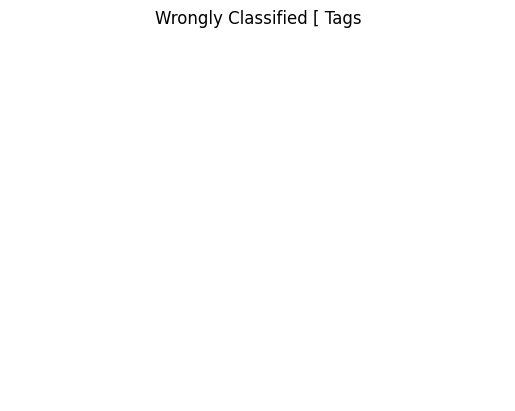

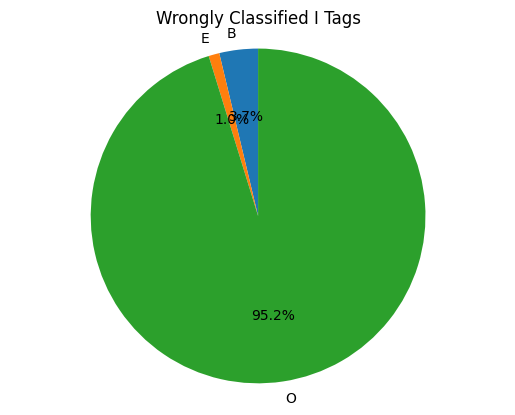

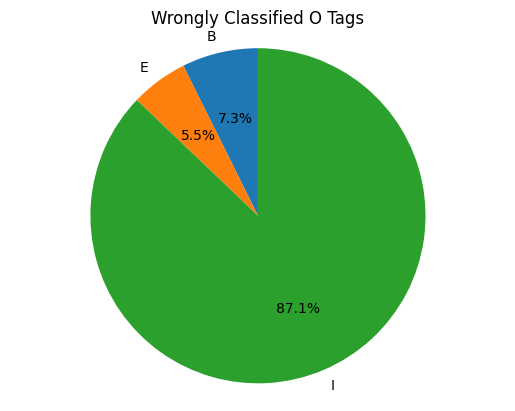

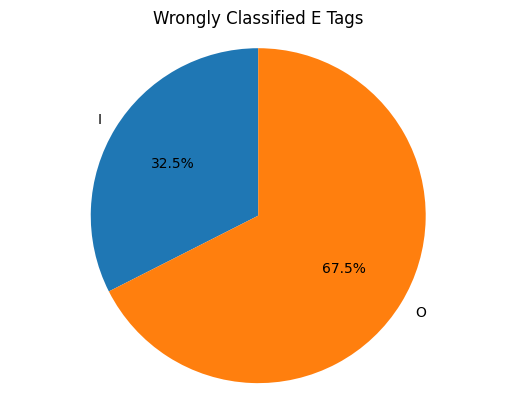

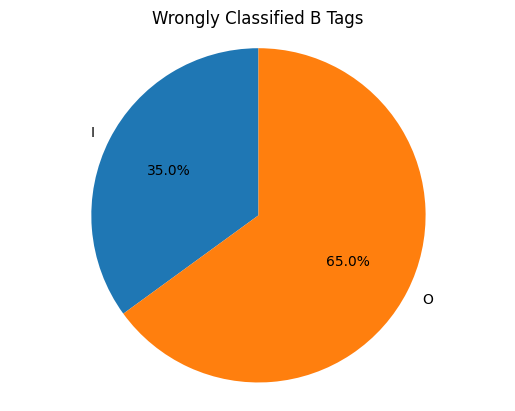

In [8]:
result_analysis(results, model, with_meta_tags=False)

In [10]:
DATADIR = "data/english_sentence_no_meta_tags"

params = {
    'model_cnn_bilstm_crf_path': str(Path(DATADIR, 'model_cnn_bilstm_crf')),
    'model_cnn_bilstm_dn_crf_path': str(Path(DATADIR, 'model_cnn_bilstm_dn_crf')),
    'model_bilstm_crf_path': str(Path(DATADIR, 'model_bilstm_crf')),
    'model_bilstm_dn_crf_path': str(Path(DATADIR, 'model_bilstm_dn_crf')),
    'full_model_cnn_bilstm_crf_path': str(Path(DATADIR, 'full_model_cnn_bilstm_crf')),
    'full_model_cnn_bilstm_dn_crf_path': str(Path(DATADIR, 'full_model_cnn_bilstm_dn_crf')),
    'full_model_bilstm_crf_path': str(Path(DATADIR, 'full_model_bilstm_crf')),
    'full_model_bilstm_dn_crf_path': str(Path(DATADIR, 'full_model_bilstm_dn_crf')),
    'model_histories_path': str(Path(DATADIR)),
    'words_path': str(Path(DATADIR, 'vocab.words.txt')),
    'chars_path': str(Path(DATADIR, 'vocab.chars.txt')),
    'tags_path': str(Path(DATADIR, 'vocab.tags.txt')),
    'sentences_path': (str(Path(DATADIR, 'train.words.txt')), str(Path(DATADIR, 'testa.words.txt')), str(Path(DATADIR, 'testb.words.txt'))),
    'labels_path': (str(Path(DATADIR, 'train.tags.txt')), str(Path(DATADIR, 'testa.tags.txt')), str(Path(DATADIR, 'testb.tags.txt'))),
}

In [11]:
load_dataset_string(params)


In [12]:
# model_name = "model_cnn_bilstm_dn_crf"
model_name = "model_cnn_bilstm_crf"
# model_name = "model_bilstm_dn_crf"
# model_name = "model_bilstm_crf"

model = keras.models.load_model(params[f"full_{model_name}_path"])

In [13]:
results = missmatch(params, model)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


Accuracy: 0.8535083147770882


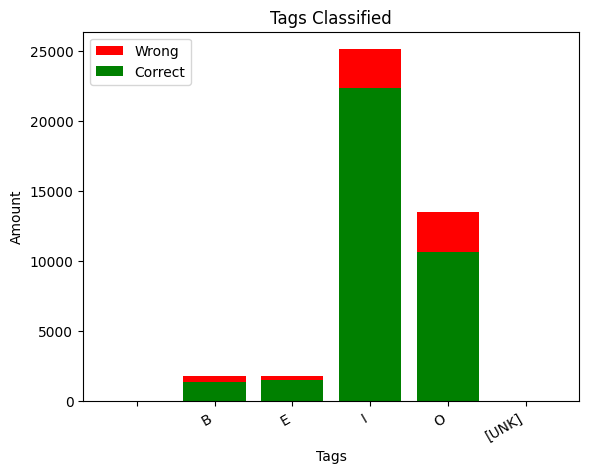

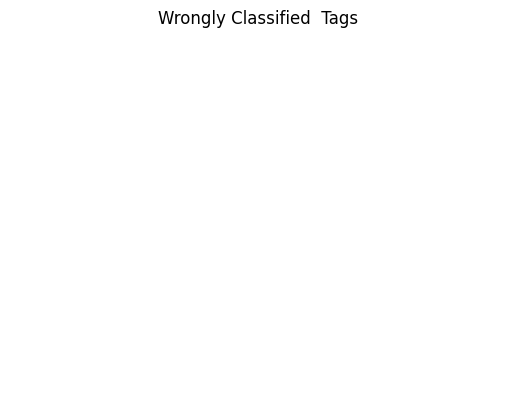

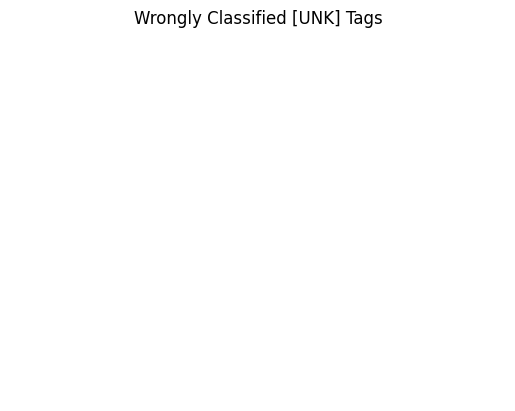

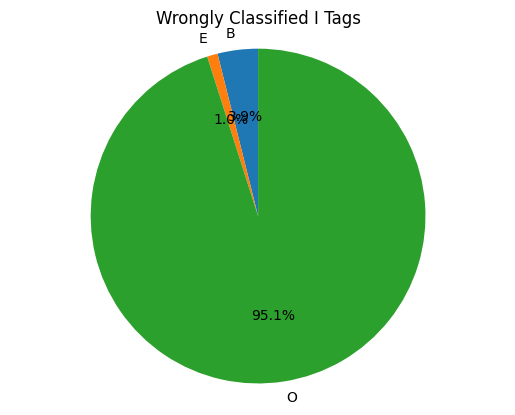

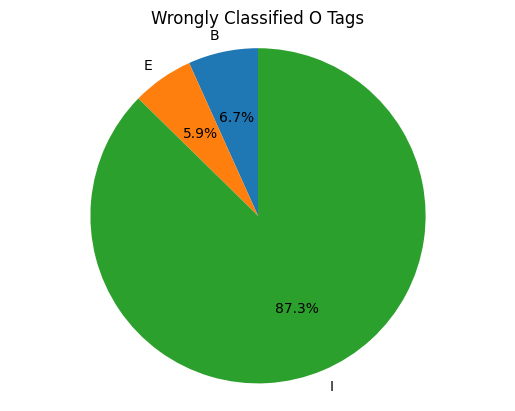

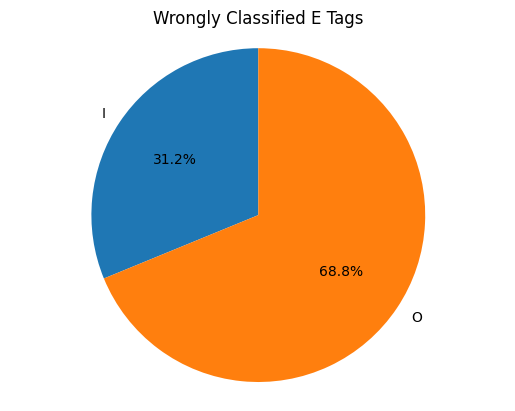

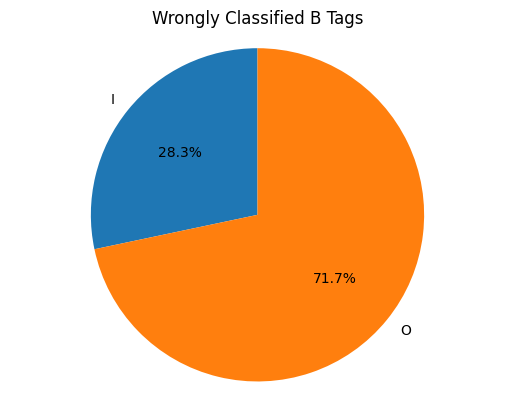

In [14]:
result_analysis(results, model)